<a href="https://colab.research.google.com/github/andres4640/Fake-News-Tesis/blob/main/FakeNews_Models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fake News

El dataset "COVID Fake News Data.csv" fue extraido de la siguiente dirección: https://zenodo.org/record/4282522#.YJ6FtsCg9Pa

El dataset "fake_new_dataset.xlsx" se obtuvo de la siguiente dirección: https://data.mendeley.com/datasets/zwfdmp5syg/1

Ambos datasets cuentan con columnas que indican si el texto es falso o verdadero. En el caso del primer dataset, la columna "outcome" representa la veracidad del texto y en el segundo dataset, la columna "label". En ambas columnas, el valor "0" representa veracidad y "1" falsedad.

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import os
os.chdir('/content/gdrive/MyDrive/Tesis/')

In [ ]:
pd.__version__

'1.2.5'

In [ ]:
pip install openpyxl==2.6.0

     |████████████████████████████████| 174kB 4.2MB/s 
  Created wheel for openpyxl: filename=openpyxl-2.6.0-py2.py3-none-any.whl size=243902 sha256=9bf54bb424b89141669a124878fe8f4b44031e4222d4e600348efd1c3c25bc8f
  Stored in directory: /root/.cache/pip/wheels/5a/de/77/f07186146bd0337342dd8c86fa12441f4f9c59573c51dcce9d
Successfully built openpyxl
  Found existing installation: openpyxl 2.5.9
    Uninstalling openpyxl-2.5.9:
      Successfully uninstalled openpyxl-2.5.9


In [ ]:
df_one = pd.read_csv("Datasets/COVID Fake News Data.csv")
df_two = pd.read_excel("Datasets/fake_new_dataset.xlsx", index_col = None)

Limpiar los caracteres que no son ASCII:

In [ ]:
df_one.outcome.value_counts()

0    9727
1     474
Name: outcome, dtype: int64

In [ ]:
df_two.label.value_counts()

1    2061
0    1058
Name: label, dtype: int64

In [ ]:
from string import printable

df_one.headlines = df_one.headlines.apply(lambda y: ''.join(filter(lambda x: 
            x in printable, y)))

In [ ]:
df_one.outcome.replace({0: 1, 1: 0}, inplace=True)
df_one.outcome.value_counts()

1    9727
0     474
Name: outcome, dtype: int64

In [ ]:
df_two.label.replace({0: 1, 1: 0}, inplace=True)
df_two.label.value_counts()

0    2061
1    1058
Name: label, dtype: int64

En el segundo dataset modificamos el nombre de las columnas para poder concatenarlo con el primer dataset

In [ ]:
df_two.rename(columns={"title": "headlines", "label": "outcome"}, inplace=True)

Concatenamos el dataset

In [ ]:
df_one_final = pd.concat([df_one, df_two[["headlines", "outcome"]]], ignore_index=True)

Podemos ver la diferencia de numero de datos entre ambas clases, hay una mayor cantidad de textos clasificados como falsos. Esto representa un desbalance de clases.

In [ ]:
df_one_final.outcome.value_counts()

1    10785
0     2535
Name: outcome, dtype: int64

In [ ]:
df_one_final

,headlines,outcome
0,A post claims compulsory vacination violates t...,1
1,A photo claims that this person is a doctor wh...,1
2,Post about a video claims that it is a protest...,1
3,All deaths by respiratory failure and pneumoni...,1
4,The dean of the College of Biologists of Euska...,1
...,...,...
13315,2019-nCoV: Health dept. on full alert,0
13316,Screening machine for corona virus launched at...,0
13317,Coronavirus (2019-nCoV),0
13318,Characterizing Patients Hospitalized With COVI...,1


Podemos ver que existe un dato que tiene valor nulo en la columna "headlines". Eliminaremos este dato, no afectara al entrenamiento debido a su numero reducido.

In [ ]:
df_one_final.isna().sum()

headlines    1
outcome      0
dtype: int64

In [ ]:

df_one_final.dropna(inplace=True)
df_one_final.reset_index(drop=True, inplace=True)

Analizamos cuantas palabras tienen como maximo, minimo y promedio las oraciones que se usaran para entrenar el modelo.

In [ ]:
# Maximo largo de una palabra antes del reproceso
print("Largo oracion Maximo ",df_one_final.headlines.str.len().max())
print("Largo oracion Minimo: ",df_one_final.headlines.str.len().min())
print("Largo oracion Promedio: ",df_one_final.headlines.str.len().mean())

Largo oracion Maximo  673
Largo oracion Minimo:  6
Largo oracion Promedio:  93.10751557924769


## Preprocesamiento de textos

Vemos el tamaño del dataset es de 13319 datos:

In [ ]:
len(df_one_final)

13319

Importamos la libreria NLTK que nos permitira aplicar tecnicas de procesamiento de lenguaje natural (NLP) en los textos:

In [ ]:
import re
import nltk
nltk.download("stopwords")

from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Aplicaremos tecnicas de pre procesamiento de textos como convertir palabras a minuscula, eliminar espacios y caracteres innecesarios, y aplicar la técnica Stemming. Como resultado obtendremos el cuerpo de los textos pre procesados para entrenar los modelos.

In [ ]:
corpus = []
lista_palabras = []
for i in range(len(df_one_final)):
  # Reemplazamos caracteres innecesarios como puntos y comas:
  #texto = re.sub("[^a-zA-Z-á-é-í-ó-ú]", " ", df_one_final["headlines"][i])
  texto = re.sub("[^a-zA-Z]", " ", df_one_final["headlines"][i])

  # Eliminamos espacios extras
  texto = re.sub(r"\s+"," ", texto, flags = re.I)

  # Convertimos el texto a minuscula:
  texto = texto.lower()

  # Dividimos el texto en palabras individuales:
  texto = texto.split()

  # Declaramos el objeto Stemming:
  stemmer = PorterStemmer()

  # Excluimos los Stop Words de los textos:
  lista_stopwords = stopwords.words("english")
  
  # Aplicamos Stemming y omitimos los Stop words:
  texto = [stemmer.stem(palabra) for palabra in texto if not palabra in set(lista_stopwords)]

  lista_palabras.append(texto)
  
  # Unimos las palabras, separados por un espacio:
  texto= " ".join(texto)

  # Añadimos el texto al corpus
  corpus.append(texto)

Creamos una funcioón para conocer el numero de palabras en el corpus:

In [ ]:
def num_palabras(corp):
  palabras_unicas = []
  lista_palabras = []
  for lista in corpus:
    lista_palabras = lista.split()
    for palabra in lista_palabras:
      if palabra not in palabras_unicas:
        palabras_unicas.append(palabra)
  return len(palabras_unicas)

In [ ]:
tamanio_voc = num_palabras(corpus)

## Desarrollo del Modelo

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 102kB 7.8MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=15a32215d20e9833ba0ab73264e60d99f6b634fb009550a374e8adec80163fd6
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Dense, Activation, Dropout, LSTM, GRU, Bidirectional
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameter
import time

ModuleNotFoundError: ignored

### Word2Vec

Descargamos el modelo pre entrenado Word2Vec, el cual se entreno con un corpus de Google News de aproximadamente 3 billones de palabras. Estas se encuentran representado como vectores de 300 dimensiones.

In [ ]:
pip install gensim

In [ ]:
from tensorflow.keras.utils import get_file
modelo_pre_entrenado = 0
if modelo_pre_entrenado == 1:
  path = get_file('GoogleNews-vectors-negative300.bin.gz', 
  origin='https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz')
  print(path)

In [ ]:
from gensim.models import word2vec
# Modelo word2vec usando la arquitectura CBOW:
model_word2vec_cbow = word2vec.Word2Vec(corpus, size=100, window=5, min_count=5, workers=12, sg=0)
#w2v_pesos_cbow = model_word2vec_cbow.wv.vectors

model_word2vec_skip = word2vec.Word2Vec(corpus, size=100, window=5, min_count=5, workers=12, sg=0)
#w2v_pesos_skip = model_word2vec_skip.wv.vectors

### Padding

Se aplica la tecnica de padding para que todas los textos tengan el mismo largo.

In [ ]:
def largo_max(corp):
  max_valor = 0
  for lista in corp:
    largo = len(lista)
    if largo > max_valor:
      max_valor = largo
  return max_valor

Tokenizamos las palabras del corpus para que puedan ser leidos por el modelo y aplicamos la tecnica llamada padding para que todas las oraciones ingresantes en el modelo de redes neuronales tengan el mismo tamaño.

In [ ]:
def tokenizar_padding(corpus_data):
  tokenizer = Tokenizer()
  tokenizer.fit_on_texts(corpus_data)
  secuencias = tokenizer.texts_to_sequences(corpus_data)
  max_len_oracion = largo_max(secuencias)
  resultado = pad_sequences(secuencias, maxlen = max_len_oracion)
  return resultado, max_len_oracion


In [ ]:
X, max_largo_oracion = tokenizar_padding(corpus)

In [ ]:
embedding_vector_size = 100
def matriz_pesos_word2vec(modelo_word2vec, corpus_data):
  voc_size = num_palabras(corpus_data)
  words = list(modelo_word2vec.wv.vocab)
  embedding_matrix = np.zeros((voc_size+1, embedding_vector_size))
  for index, word in enumerate(words):    
    embedding_vector = modelo_word2vec.wv[word]
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector
  return embedding_matrix

In [ ]:
embedding_matrix_cbow = matriz_pesos_word2vec(model_word2vec_cbow, corpus)
embedding_matrix_skip = matriz_pesos_word2vec(model_word2vec_skip, corpus)

## Modelo LSTM y Word2vec 

### Modelo LSTM - CBOW

In [ ]:
def LSTM_One_Word2Vec_CBOW(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_cbow]))
  
  model.add(LSTM(hp.Int("LSTM_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1)
                 ))
  
  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

##################

def LSTM_Two_Word2Vec_CBOW(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_cbow]))

  model.add(LSTM(hp.Int("LSTM_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1),
                 return_sequences=True
                 ))

  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  model.add(LSTM(hp.Int(f"LSTM2_units", 32, 256, 32),
                   recurrent_dropout=hp.Float(f"dropout_rec2_unit", 0.1, 0.5, 0.1)))
  model.add(Dropout(hp.Float(f"dropout2_unit", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

### Modelos LSTM - Skip Gram

In [ ]:
def LSTM_One_Word2Vec_SKIP(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_skip]))
  
  model.add(LSTM(hp.Int("LSTM_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1)
                 ))
  
  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

##################

def LSTM_Two_Word2Vec_SKIP(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_skip]))

  model.add(LSTM(hp.Int("LSTM_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1),
                 return_sequences=True
                 ))

  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  model.add(LSTM(hp.Int(f"LSTM2_units", 32, 256, 32),
                   recurrent_dropout=hp.Float(f"dropout_rec2_unit", 0.1, 0.5, 0.1)))
  model.add(Dropout(hp.Float(f"dropout2_unit", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

## Modelo GRU - Word2vec

In [ ]:
def GRU_One_Word2Vec_CBOW(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_cbow]))
  
  model.add(GRU(hp.Int("GRU_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1)
                 ))
  
  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

##################

def GRU_Two_Word2Vec_CBOW(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_cbow]))

  model.add(GRU(hp.Int("GRU_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1),
                 return_sequences=True
                 ))

  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  model.add(GRU(hp.Int(f"GRU2_units", 32, 256, 32),
                   recurrent_dropout=hp.Float(f"dropout_rec2_unit", 0.1, 0.5, 0.1)))
  model.add(Dropout(hp.Float(f"dropout2_unit", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

### Modelo GRU - SKIP

In [ ]:
def GRU_One_Word2Vec_SKIP(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_skip]))
  
  model.add(GRU(hp.Int("GRU_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1)
                 ))
  
  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

##################

def GRU_Two_Word2Vec_SKIP(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_skip]))

  model.add(GRU(hp.Int("GRU_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1),
                 return_sequences=True
                 ))

  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  model.add(GRU(hp.Int(f"GRU2_units", 32, 256, 32),
                   recurrent_dropout=hp.Float(f"dropout_rec2_unit", 0.1, 0.5, 0.1)))
  model.add(Dropout(hp.Float(f"dropout2_unit", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

## Modelo LSTM Bidireccional 

In [ ]:
def BiLSTM_One_Word2Vec_CBOW(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_cbow]))
  
  model.add(Bidirectional(LSTM(hp.Int("BiLSTM_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1)
                 )))
  
  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

##################

def BiLSTM_Two_Word2Vec_CBOW(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_cbow]))

  model.add(Bidirectional(LSTM(hp.Int("BiLSTM_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1),
                 return_sequences=True
                 )))

  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  model.add(Bidirectional(LSTM(hp.Int(f"BiLSTM_units", 32, 256, 32),
                   recurrent_dropout=hp.Float(f"dropout_rec2_unit", 0.1, 0.5, 0.1))))
  model.add(Dropout(hp.Float(f"dropout2_unit", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

def BiLSTM_One_Word2Vec_SKIP(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_skip]))
  
  model.add(Bidirectional(LSTM(hp.Int("BiLSTM_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1)
                 )))
  
  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

##################

def BiLSTM_Two_Word2Vec_SKIP(hp):
  model=Sequential()
  
  model.add(Embedding(tamanio_voc+1, 
                      embedding_vector_size, 
                      input_length=max_largo_oracion, 
                      weights = [embedding_matrix_skip]))

  model.add(Bidirectional(LSTM(hp.Int("BiLSTM_units_one", 32, 256, 32), 
                 recurrent_dropout=hp.Float("dropout_rec_unit_one", 0.1, 0.5, 0.1),
                 return_sequences=True
                 )))

  model.add(Dropout(hp.Float("dropout_unit_one", 0.1, 0.5, 0.1)))

  model.add(Bidirectional(LSTM(hp.Int(f"BiLSTM_units", 32, 256, 32),
                   recurrent_dropout=hp.Float(f"dropout_rec2_unit", 0.1, 0.5, 0.1))))
  model.add(Dropout(hp.Float(f"dropout2_unit", 0.1, 0.5, 0.1)))

  for i in range(hp.Int("n_capas_dense", 0, 3, 1)):
    if i == 0:
      pass
    else:
      model.add(Dense(hp.Int(f"dense_units_{i}", 32, 256, 32), 
                    activation='relu'))
      model.add(Dropout(hp.Float("dropout_unit_three", 0.1, 0.5, 0.1)))

  model.add(Dense(1,activation='sigmoid'))

  model.compile(loss ='binary_crossentropy',
                optimizer='adam',
                metrics=['accuracy'])
  return model

## Modelo LSTM y BERT

In [ ]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

fatal: destination path 'models' already exists and is not an empty directory.


In [ ]:
!pip install -Uqr models/official/requirements.txt

     |████████████████████████████████| 7.0MB 4.3MB/s 
     |████████████████████████████████| 194kB 39.4MB/s 
     |████████████████████████████████| 15.7MB 191kB/s 
     |████████████████████████████████| 9.9MB 19.9MB/s 
     |████████████████████████████████| 296kB 37.6MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 28.5MB 209kB/s 
     |████████████████████████████████| 215kB 40.8MB/s 
     |████████████████████████████████| 3.9MB 17.9MB/s 
     |████████████████████████████████| 686kB 39.3MB/s 
     |████████████████████████████████| 358kB 38.9MB/s 
     |████████████████████████████████| 1.2MB 31.8MB/s 
     |████████████████████████████████| 10.3MB 38.4MB/s 
     |████████████████████████████████| 38.2MB 95kB/s 
     |████████████████████████████████| 645kB 28.0MB/s 
     |████████████████████████████████| 3.0MB 34.9MB/s 
     |████████████████████████████████| 81kB 10.4MB/s 
     |████████████████████████████████| 51kB 7.6MB

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import sys
sys.path.append('models')
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

ModuleNotFoundError: ignored

In [ ]:
label_list = list(df_one_final.outcome.unique())
max_seq_length = max_largo_oracion
train_batch_size = 32

# Get BERT layer and tokenizer:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2",
                            trainable=True)
# Ahora instanciar el Tokenizador que realizara el preprocesamiento y tokenizacion de los datos.
  # Requiere el vocabulario de BERT
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()

# Asegurarnos que estamos usando la version uncased de BERT -> Cased o Uncased. -> Revisara el archivo almacenado en el Modelo. 
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

# Instanciamos el Tokenizador
  # Le enviamos el vocabulario y si es un modelo Cased. 
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
def to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
  example = classifier_data_lib.InputExample(guid = None,
                                            text_a = text.numpy(), 
                                            text_b = None, 
                                            label = label.numpy())

  feature = classifier_data_lib.convert_single_example(0, example, label_list,
                                    max_seq_length, tokenizer)
  
  return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)

In [ ]:
def to_feature_map(text, label):
  input_ids, input_mask, segment_ids, label_id = tf.py_function(to_feature, inp=[text, label], 
                                Tout=[tf.int32, tf.int32, tf.int32, tf.int32])
  input_ids.set_shape([max_seq_length])
  input_mask.set_shape([max_seq_length])
  segment_ids.set_shape([max_seq_length])
  label_id.set_shape([]) 

  x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }
  return (x, label_id)

In [ ]:
def BERT_modelo(hp):
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="input_word_ids")
  input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_mask")
  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                  name="input_type_ids")

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(hp.Float(f"dropout_unit", 0.1, 0.5, 0.1))(pooled_output) 

  output = tf.keras.layers.Dense(1, activation="sigmoid", name="output")(drop)

  model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': input_type_ids
    },
    outputs=output)
  
  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
  
  return model

# Dividir Dataset

In [ ]:
y = np.array(df_one_final.outcome)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Desbalanceo del dataset

Aplicaremos una combinación de tecnicas de Undersampling y Oversampling para poder tener reducir el desbalance del dataset.

Undersampling -> Reduce el número de la clase mayoritaria al azar a la proporción deseada contra la clase minoritaria. 

OverSampling -> Duplicamos los datos que tienen la clase minoritaria o creamos nuevos ejemplos sinteticos. En el caso de un dataset de texto, no recomendable crear ejemplos.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

over = RandomOverSampler(sampling_strategy=0.4)
under = RandomUnderSampler(sampling_strategy=0.5)
print("Antes de aplicar las tecnicas: ", Counter(y_train))
X_train, y_train = over.fit_resample(X_train, y_train)
print("Despues de aplicar Oversampling: ", Counter(y_train))
X_train, y_train = under.fit_resample(X_train, y_train)
print("Despues de aplicar Undersampling: ", Counter(y_train))

Antes de aplicar las tecnicas:  Counter({1: 8611, 0: 2044})
Despues de aplicar Oversampling:  Counter({1: 8611, 0: 3444})
Despues de aplicar Undersampling:  Counter({1: 6888, 0: 3444})


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


# Entrenar Modelos

Aplicamos el objeto Tuner de Keras para poder ver cuales son los mejores hiperparametros para nuesto modelo

In [ ]:
tuner_lstm_cbow_one = RandomSearch(LSTM_One_Word2Vec_CBOW, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_lstm_cbow_one")
tuner_lstm_cbow_one.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

Trial 1 Complete [00h 05m 02s]
val_accuracy: 0.912912905216217

Best val_accuracy So Far: 0.912912905216217
Total elapsed time: 00h 05m 02s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_lstm_cbow_dos = RandomSearch(LSTM_Two_Word2Vec_CBOW, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_lstm_cbow_dos")
tuner_lstm_cbow_dos.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

Trial 1 Complete [00h 09m 22s]
val_accuracy: 0.912912905216217

Best val_accuracy So Far: 0.912912905216217
Total elapsed time: 00h 09m 22s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_lstm_skip_uno = RandomSearch(LSTM_One_Word2Vec_SKIP, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_lstm_skip_uno")
tuner_lstm_skip_uno.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

Trial 1 Complete [00h 05m 00s]
val_accuracy: 0.9110360145568848

Best val_accuracy So Far: 0.9110360145568848
Total elapsed time: 00h 05m 00s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_lstm_skip_dos = RandomSearch(LSTM_Two_Word2Vec_SKIP, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_lstm_skip_dos")
tuner_lstm_skip_dos.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

Trial 1 Complete [00h 09m 27s]
val_accuracy: 0.9076576828956604

Best val_accuracy So Far: 0.9076576828956604
Total elapsed time: 00h 09m 27s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_gru_cbow_uno = RandomSearch(GRU_One_Word2Vec_CBOW, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_gru_cbow_uno")
tuner_gru_cbow_uno.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

Trial 1 Complete [00h 04m 29s]
val_accuracy: 0.9039039015769958

Best val_accuracy So Far: 0.9039039015769958
Total elapsed time: 00h 04m 29s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_gru_cbow_dos = RandomSearch(GRU_Two_Word2Vec_CBOW, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_gru_cbow_dos")
tuner_gru_cbow_dos.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

Trial 1 Complete [00h 09m 25s]
val_accuracy: 0.9144144058227539

Best val_accuracy So Far: 0.9144144058227539
Total elapsed time: 00h 09m 25s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_gru_skip_uno = RandomSearch(GRU_One_Word2Vec_SKIP, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_gru_skip_uno")
tuner_gru_skip_uno.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

Trial 1 Complete [00h 05m 24s]
val_accuracy: 0.9166666865348816

Best val_accuracy So Far: 0.9166666865348816
Total elapsed time: 00h 05m 24s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner_gru_skip_dos = RandomSearch(GRU_Two_Word2Vec_SKIP, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_gru_skip_dos")
tuner_gru_skip_dos.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

Trial 1 Complete [00h 09m 25s]
val_accuracy: 0.9151651859283447

Best val_accuracy So Far: 0.9151651859283447
Total elapsed time: 00h 09m 25s
INFO:tensorflow:Oracle triggered exit


BiLSTM

In [ ]:
tuner_bilstm_cbow_uno = RandomSearch(BiLSTM_One_Word2Vec_CBOW, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_bilstm_cbow_uno")
tuner_bilstm_cbow_uno.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

#####
tuner_bilstm_cbow_dos = RandomSearch(BiLSTM_Two_Word2Vec_CBOW, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_bilstm_cbow_dos")
tuner_bilstm_cbow_dos.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

####
tuner_bilstm_skip_uno = RandomSearch(BiLSTM_One_Word2Vec_SKIP, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_bilstm_skip_uno")
tuner_bilstm_skip_uno.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

####
tuner_bilstm_skip_dos = RandomSearch(BiLSTM_Two_Word2Vec_SKIP, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_bilstm_skip_dos")
tuner_bilstm_skip_dos.search(x=X_train,
             y=y_train,
             epochs=5,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

Trial 1 Complete [00h 18m 31s]
val_accuracy: 0.9159159064292908

Best val_accuracy So Far: 0.9159159064292908
Total elapsed time: 00h 18m 31s
INFO:tensorflow:Oracle triggered exit


In [ ]:
print(tuner_bilstm_cbow_uno.get_best_hyperparameters()[0].values)
print(tuner_bilstm_cbow_uno.results_summary())

{'BiLSTM_units_one': 192, 'dropout_rec_unit_one': 0.4, 'dropout_unit_one': 0.30000000000000004, 'n_capas_dense': 1}
Results summary
Results in tuner_bilstm_cbow_uno/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
BiLSTM_units_one: 192
dropout_rec_unit_one: 0.4
dropout_unit_one: 0.30000000000000004
n_capas_dense: 1
Score: 0.9162912964820862
None


In [ ]:
print(tuner_bilstm_cbow_dos.get_best_hyperparameters()[0].values)
print(tuner_bilstm_cbow_dos.results_summary())

{'BiLSTM_units_one': 160, 'dropout_rec_unit_one': 0.2, 'dropout_unit_one': 0.2, 'BiLSTM_units': 224, 'dropout_rec2_unit': 0.1, 'dropout2_unit': 0.1, 'n_capas_dense': 1}
Results summary
Results in tuner_bilstm_cbow_dos/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
BiLSTM_units_one: 160
dropout_rec_unit_one: 0.2
dropout_unit_one: 0.2
BiLSTM_units: 224
dropout_rec2_unit: 0.1
dropout2_unit: 0.1
n_capas_dense: 1
Score: 0.9181681871414185
None


In [ ]:
print(tuner_bilstm_skip_uno.get_best_hyperparameters()[0].values)
print(tuner_bilstm_skip_uno.results_summary())

{'BiLSTM_units_one': 224, 'dropout_rec_unit_one': 0.2, 'dropout_unit_one': 0.4, 'n_capas_dense': 2, 'dense_units_1': 32, 'dropout_unit_three': 0.1}
Results summary
Results in tuner_bilstm_skip_uno/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
BiLSTM_units_one: 224
dropout_rec_unit_one: 0.2
dropout_unit_one: 0.4
n_capas_dense: 2
dense_units_1: 32
dropout_unit_three: 0.1
Score: 0.907282292842865
None


In [ ]:
print(tuner_bilstm_skip_dos.get_best_hyperparameters()[0].values)
print(tuner_bilstm_skip_dos.results_summary())

{'BiLSTM_units_one': 96, 'dropout_rec_unit_one': 0.30000000000000004, 'dropout_unit_one': 0.4, 'BiLSTM_units': 128, 'dropout_rec2_unit': 0.30000000000000004, 'dropout2_unit': 0.5, 'n_capas_dense': 1}
Results summary
Results in tuner_bilstm_skip_dos/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
BiLSTM_units_one: 96
dropout_rec_unit_one: 0.30000000000000004
dropout_unit_one: 0.4
BiLSTM_units: 128
dropout_rec2_unit: 0.30000000000000004
dropout2_unit: 0.5
n_capas_dense: 1
Score: 0.9159159064292908
None


In [ ]:
 print(tuner_lstm_cbow_one.get_best_hyperparameters()[0].values)
 print(tuner_lstm_cbow_one.results_summary())

{'LSTM_units_one': 128, 'dropout_rec_unit_one': 0.4, 'dropout_unit_one': 0.1, 'n_capas_dense': 3, 'dense_units_1': 32, 'dropout_unit_three': 0.1, 'dense_units_2': 32}
Results summary
Results in tuner_lstm_cbow_one/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
LSTM_units_one: 128
dropout_rec_unit_one: 0.4
dropout_unit_one: 0.1
n_capas_dense: 3
dense_units_1: 32
dropout_unit_three: 0.1
dense_units_2: 32
Score: 0.912912905216217
None


In [ ]:
 print(tuner_lstm_cbow_dos.get_best_hyperparameters()[0].values)
 print(tuner_lstm_cbow_dos.results_summary())

{'LSTM_units_one': 96, 'dropout_rec_unit_one': 0.30000000000000004, 'dropout_unit_one': 0.4, 'LSTM2_units': 64, 'dropout_rec2_unit': 0.2, 'dropout2_unit': 0.2, 'n_capas_dense': 1}
Results summary
Results in tuner_lstm_cbow_dos/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
LSTM_units_one: 96
dropout_rec_unit_one: 0.30000000000000004
dropout_unit_one: 0.4
LSTM2_units: 64
dropout_rec2_unit: 0.2
dropout2_unit: 0.2
n_capas_dense: 1
Score: 0.912912905216217
None


In [ ]:
 print(tuner_lstm_skip_uno.get_best_hyperparameters()[0].values)
 print(tuner_lstm_skip_uno.results_summary())

{'LSTM_units_one': 128, 'dropout_rec_unit_one': 0.2, 'dropout_unit_one': 0.4, 'n_capas_dense': 3, 'dense_units_1': 32, 'dropout_unit_three': 0.1, 'dense_units_2': 32}
Results summary
Results in tuner_lstm_skip_uno/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
LSTM_units_one: 128
dropout_rec_unit_one: 0.2
dropout_unit_one: 0.4
n_capas_dense: 3
dense_units_1: 32
dropout_unit_three: 0.1
dense_units_2: 32
Score: 0.9110360145568848
None


In [ ]:
 print(tuner_lstm_skip_dos.get_best_hyperparameters()[0].values)
 print(tuner_lstm_skip_dos.results_summary())

{'LSTM_units_one': 224, 'dropout_rec_unit_one': 0.1, 'dropout_unit_one': 0.2, 'LSTM2_units': 96, 'dropout_rec2_unit': 0.2, 'dropout2_unit': 0.2, 'n_capas_dense': 2, 'dense_units_1': 32, 'dropout_unit_three': 0.1}
Results summary
Results in tuner_lstm_skip_dos/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
LSTM_units_one: 224
dropout_rec_unit_one: 0.1
dropout_unit_one: 0.2
LSTM2_units: 96
dropout_rec2_unit: 0.2
dropout2_unit: 0.2
n_capas_dense: 2
dense_units_1: 32
dropout_unit_three: 0.1
Score: 0.9076576828956604
None


In [ ]:
print(tuner_gru_cbow_uno.get_best_hyperparameters()[0].values)
print(tuner_gru_cbow_uno.results_summary())

{'GRU_units_one': 256, 'dropout_rec_unit_one': 0.2, 'dropout_unit_one': 0.4, 'n_capas_dense': 0}
Results summary
Results in tuner_gru_cbow_uno/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
GRU_units_one: 256
dropout_rec_unit_one: 0.2
dropout_unit_one: 0.4
n_capas_dense: 0
Score: 0.9039039015769958
None


In [ ]:
print(tuner_gru_cbow_dos.get_best_hyperparameters()[0].values)
print(tuner_gru_cbow_dos.results_summary())

{'GRU_units_one': 32, 'dropout_rec_unit_one': 0.2, 'dropout_unit_one': 0.2, 'GRU2_units': 128, 'dropout_rec2_unit': 0.1, 'dropout2_unit': 0.30000000000000004, 'n_capas_dense': 3, 'dense_units_1': 32, 'dropout_unit_three': 0.1, 'dense_units_2': 32}
Results summary
Results in tuner_gru_cbow_dos/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
GRU_units_one: 32
dropout_rec_unit_one: 0.2
dropout_unit_one: 0.2
GRU2_units: 128
dropout_rec2_unit: 0.1
dropout2_unit: 0.30000000000000004
n_capas_dense: 3
dense_units_1: 32
dropout_unit_three: 0.1
dense_units_2: 32
Score: 0.9144144058227539
None


In [ ]:
print(tuner_gru_skip_uno.get_best_hyperparameters()[0].values)
print(tuner_gru_skip_uno.results_summary())

{'GRU_units_one': 64, 'dropout_rec_unit_one': 0.4, 'dropout_unit_one': 0.2, 'n_capas_dense': 3, 'dense_units_1': 32, 'dropout_unit_three': 0.1, 'dense_units_2': 32}
Results summary
Results in tuner_gru_skip_uno/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
GRU_units_one: 64
dropout_rec_unit_one: 0.4
dropout_unit_one: 0.2
n_capas_dense: 3
dense_units_1: 32
dropout_unit_three: 0.1
dense_units_2: 32
Score: 0.9166666865348816
None


In [ ]:
print(tuner_gru_skip_dos.get_best_hyperparameters()[0].values)
print(tuner_gru_skip_dos.results_summary())

{'GRU_units_one': 224, 'dropout_rec_unit_one': 0.4, 'dropout_unit_one': 0.1, 'GRU2_units': 64, 'dropout_rec2_unit': 0.1, 'dropout2_unit': 0.4, 'n_capas_dense': 1}
Results summary
Results in tuner_gru_skip_dos/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
GRU_units_one: 224
dropout_rec_unit_one: 0.4
dropout_unit_one: 0.1
GRU2_units: 64
dropout_rec2_unit: 0.1
dropout2_unit: 0.4
n_capas_dense: 1
Score: 0.9151651859283447
None


Prueba BERT


In [ ]:
train_df, valid_df = train_test_split(df_one_final, random_state=42, train_size=0.8, stratify=df_one_final.outcome.values)
train_df.shape, valid_df.shape

In [ ]:
with tf.device('/cpu:0'):
  train_data = tf.data.Dataset.from_tensor_slices((train_df.headlines.values, train_df.outcome.values))
  valid_data = tf.data.Dataset.from_tensor_slices((valid_df.headlines.values, valid_df.outcome.values))

In [ ]:
with tf.device('/cpu:0'):
  # train
  train_data = (train_data.map(to_feature_map,
                              num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .shuffle(1000)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE))

  valid_data = (valid_data.map(to_feature_map,
                            num_parallel_calls=tf.data.experimental.AUTOTUNE)
                          .batch(32, drop_remainder=True)
                          .prefetch(tf.data.experimental.AUTOTUNE)) 

In [ ]:
tuner_bert = RandomSearch(BERT_modelo, 
                     objective = "val_accuracy",
                     max_trials = 1,
                     executions_per_trial = 1,
                     directory = "tuner_bert")
tuner_bert.search(x=X_train,
             y=y_train,
             epochs=3,
             batch_size = 32,
             validation_data = (X_test, y_test),
             verbose=2)

In [ ]:
print(tuner_bert.get_best_hyperparameters()[0].values)
print(tuner_bert.results_summary())

Seleccionamos los mejores modelos, que tuvieron el mejor accuracy y los almacenamos.

In [ ]:
LSTM_UnaCapas_CBOW = tuner_lstm_cbow_one.get_best_models()[0]
LSTM_DosCapas_CBOW = tuner_lstm_cbow_dos.get_best_models()[0]

LSTM_UnaCapas_SKIP = tuner_lstm_skip_uno.get_best_models()[0]
LSTM_DosCapas_SKIP = tuner_lstm_skip_dos.get_best_models()[0]

GRU_UnaCapas_CBOW = tuner_gru_cbow_uno.get_best_models()[0]
GRU_DosCapas_CBOW = tuner_gru_cbow_dos.get_best_models()[0]

GRU_UnaCapas_SKIP = tuner_gru_skip_uno.get_best_models()[0]
GRU_DosCapas_SKIP = tuner_gru_skip_dos.get_best_models()[0]

BiLSTM_UnaCapas_CBOW = tuner_bilstm_cbow_uno.get_best_models()[0]
BiLSTM_DosCapas_CBOW = tuner_bilstm_cbow_dos.get_best_models()[0]

BiLSTM_UnaCapas_SKIP = tuner_bilstm_skip_uno.get_best_models()[0]
BiLSTM_DosCapas_SKIP = tuner_bilstm_skip_dos.get_best_models()[0]

In [ ]:
BERT_modelo_final = tuner_bert.get_best_models()[0]

In [ ]:
LSTM_UnaCapas_CBOW.save('LSTM_UnaCapas_CBOW.h5')
LSTM_DosCapas_CBOW.save('LSTM_DosCapas_CBOW.h5')
LSTM_UnaCapas_SKIP.save('LSTM_UnaCapas_SKIP.h5')
LSTM_DosCapas_SKIP.save('LSTM_DosCapas_SKIP.h5')

GRU_UnaCapas_CBOW.save('GRU_UnaCapas_CBOW.h5')
GRU_DosCapas_CBOW.save('GRU_DosCapas_CBOW.h5')
GRU_UnaCapas_SKIP.save('GRU_UnaCapas_SKIP.h5')
GRU_DosCapas_SKIP.save('GRU_DosCapas_SKIP.h5')

BiLSTM_UnaCapas_CBOW.save('BiLSTM_UnaCapas_CBOW.h5')
BiLSTM_DosCapas_CBOW.save('BiLSTM_DosCapas_CBOW.h5')
BiLSTM_UnaCapas_SKIP.save('BiLSTM_UnaCapas_SKIP.h5')
BiLSTM_DosCapas_SKIP.save('BiLSTM_DosCapas_SKIP.h5')

In [ ]:
BERT_modelo_final.save('BERT_modelo_final.h5')

In [ ]:
BiLSTM_DosCapas_CBOW.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 64, 100)           943900    
_________________________________________________________________
bidirectional (Bidirectional (None, 64, 320)           334080    
_________________________________________________________________
dropout (Dropout)            (None, 64, 320)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 448)               976640    
_________________________________________________________________
dropout_1 (Dropout)          (None, 448)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 449       
Total params: 2,255,069
Trainable params: 2,255,069
Non-trainable params: 0
______________________________________________

Almacenamos los Tuners:

In [ ]:
import pickle

In [ ]:
with open()

In [ ]:
LSTM_Word2vec_cbow.fit(X_train,y_train,validation_data=(X_train,y_train),epochs=10,batch_size=64)

Epoch 1/10
162/162 [==============================] - 37s 210ms/step - loss: 0.3484 - accuracy: 0.8501 - val_loss: 0.1713 - val_accuracy: 0.9400
Epoch 2/10
162/162 [==============================] - 33s 207ms/step - loss: 0.1568 - accuracy: 0.9401 - val_loss: 0.1103 - val_accuracy: 0.9643
Epoch 3/10
162/162 [==============================] - 34s 208ms/step - loss: 0.1083 - accuracy: 0.9611 - val_loss: 0.0808 - val_accuracy: 0.9744
Epoch 4/10
162/162 [==============================] - 33s 205ms/step - loss: 0.0816 - accuracy: 0.9729 - val_loss: 0.0589 - val_accuracy: 0.9812
Epoch 5/10
162/162 [==============================] - 35s 214ms/step - loss: 0.0677 - accuracy: 0.9768 - val_loss: 0.0544 - val_accuracy: 0.9832
Epoch 6/10
162/162 [==============================] - 34s 208ms/step - loss: 0.0587 - accuracy: 0.9796 - val_loss: 0.0428 - val_accuracy: 0.9861
Epoch 7/10
162/162 [==============================] - 34s 208ms/step - loss: 0.0854 - accuracy: 0.9700 - val_loss: 0.0427 - val_ac

In [ ]:
LSTM_Word2vec_skip.fit(X_train,y_train,validation_data=(X_train,y_train),epochs=10,batch_size=64)

Epoch 1/10
162/162 [==============================] - 38s 218ms/step - loss: 0.3398 - accuracy: 0.8538 - val_loss: 0.1620 - val_accuracy: 0.9414
Epoch 2/10
162/162 [==============================] - 35s 217ms/step - loss: 0.1599 - accuracy: 0.9403 - val_loss: 0.1115 - val_accuracy: 0.9609
Epoch 3/10
162/162 [==============================] - 33s 206ms/step - loss: 0.1093 - accuracy: 0.9615 - val_loss: 0.0753 - val_accuracy: 0.9756
Epoch 4/10
162/162 [==============================] - 33s 205ms/step - loss: 0.0828 - accuracy: 0.9721 - val_loss: 0.0619 - val_accuracy: 0.9814
Epoch 5/10
162/162 [==============================] - 33s 206ms/step - loss: 0.0668 - accuracy: 0.9786 - val_loss: 0.0507 - val_accuracy: 0.9843
Epoch 6/10
162/162 [==============================] - 33s 206ms/step - loss: 0.0587 - accuracy: 0.9802 - val_loss: 0.0450 - val_accuracy: 0.9851
Epoch 7/10
162/162 [==============================] - 34s 211ms/step - loss: 0.0547 - accuracy: 0.9824 - val_loss: 0.0427 - val_ac

In [ ]:
y_pred_cbow = LSTM_Word2vec_cbow.predict(X_test)
y_pred_skip = LSTM_Word2vec_skip.predict(X_test)


_, prob_lstm =clasificar(LSTM_UnaCapas_CBOW)
_, prob_gru_cbow = clasificar(GRU_DosCapas_CBOW)
_, prob_gru_skip = clasificar(GRU_UnaCapas_SKIP)
_, prob_bilstm = clasificar(BiLSTM_DosCapas_CBOW)

# Cargamos los Modelos

En caso se guardaron

In [ ]:
cargar_modelos = 1
if cargar_modelos == 1:
  LSTM_UnaCapas_CBOW = tf.keras.models.load_model('Modelos/LSTM_UnaCapas_CBOW.h5')
  GRU_DosCapas_CBOW = tf.keras.models.load_model('Modelos/GRU_DosCapas_CBOW.h5')
  GRU_UnaCapas_SKIP = tf.keras.models.load_model('Modelos/GRU_UnaCapas_SKIP.h5')
  BiLSTM_DosCapas_CBOW = tf.keras.models.load_model('Modelos/BiLSTM_DosCapas_CBOW.h5')
  LSTM_UnaCapas_CBOW = tf.keras.models.load_model('Modelos/LSTM_UnaCapas_CBOW.h5')

In [ ]:
modelo_BERT =  tf.keras.models.load_model('Modelos/ModeloBERT.h5',custom_objects={'KerasLayer':hub.KerasLayer})

In [ ]:
prob_BERT = pd.read_csv('prob_BERT.csv', sep=',',header=None)
prob_BERT = prob_BERT.values

In [ ]:
def clasificar(modelo):
  y_data = modelo.predict(X_test)
  y_pred_final = []
  y_pred_lista = []
  for x in y_data:
    for y in x:
      y_pred_lista.append(y)
      if y >= 0.5:
        y_pred_final.append(1)
      else:
        y_pred_final.append(0)
  return np.array(y_pred_final), np.array(y_pred_lista)

In [ ]:
y_final_cbow, y_probs_cbow = clasificar(y_pred_cbow)
y_final_skip, y_probs_skip = clasificar(y_pred_skip)

# Metricas de Clasificación

## Matriz de confusión

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score,recall_score,f1_score, precision_score
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def evaluar_modelo(modelo, nombre, matriz = False): 
    y_pred, _ = clasificar(modelo)
    matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    if matriz == True:
      plt.figure(figsize=(10,5))
      group_names = ['True Neg','False Pos','False Neg','True Pos']
      group_counts = ["{0:0.0f}".format(value) for value in
                      matrix.flatten()]
      group_percentages = ["{0:.2%}".format(value) for value in
                          matrix.flatten()/np.sum(matrix)]
      labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
                zip(group_names,group_counts,group_percentages)]
      labels = np.asarray(labels).reshape(2,2)
      ax = sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')
      bottom, top = ax.get_ylim()
      ax.set_ylim(bottom + 0.5, top - 0.5)
      plt.title(nombre)
      plt.show()

    print("---> Nombre Modelo: ", nombre)
    print("\nAccuracy: ", accuracy)
    print("\nRecall: ", recall)
    print("\nF1-Score: ", f1)
    print("\nPrecision: ", precision)
    print("")

In [ ]:
evaluar_modelo(LSTM_UnaCapas_CBOW, 'LSTM-UnaCapa-CBOW')
evaluar_modelo(LSTM_DosCapas_CBOW, 'LSTM-DosCapa-CBOW')
evaluar_modelo(LSTM_UnaCapas_SKIP, 'LSTM_UnaCapas_SKIP')
evaluar_modelo(LSTM_DosCapas_SKIP, 'LSTM_DosCapas_SKIP')

evaluar_modelo(GRU_UnaCapas_CBOW, 'GRU_UnaCapas_CBOW')
evaluar_modelo(GRU_DosCapas_CBOW, 'GRU_DosCapas_CBOW')
evaluar_modelo(GRU_UnaCapas_SKIP, 'GRU_UnaCapas_SKIP')
evaluar_modelo(GRU_DosCapas_SKIP, 'GRU_DosCapas_SKIP')

evaluar_modelo(BiLSTM_UnaCapas_CBOW, 'BiLSTM_UnaCapas_CBOW')
evaluar_modelo(BiLSTM_DosCapas_CBOW, 'BiLSTM_DosCapas_CBOW')
evaluar_modelo(BiLSTM_UnaCapas_SKIP, 'BiLSTM_UnaCapas_SKIP')
evaluar_modelo(BiLSTM_DosCapas_SKIP, 'BiLSTM_DosCapas_SKIP')

---> Nombre Modelo:  LSTM-UnaCapa-CBOW

Accuracy:  0.9129129129129129

Recall:  0.9470777726645191

F1-Score:  0.9466421343146274

Precision:  0.9462068965517242

---> Nombre Modelo:  LSTM-DosCapa-CBOW

Accuracy:  0.9129129129129129

Recall:  0.9295904279797514

F1-Score:  0.9456928838951311

Precision:  0.9623630300142926

---> Nombre Modelo:  LSTM_UnaCapas_SKIP

Accuracy:  0.911036036036036

Recall:  0.931891394385642

F1-Score:  0.9447165850244926

Precision:  0.9578997161778618

---> Nombre Modelo:  LSTM_DosCapas_SKIP

Accuracy:  0.9076576576576577

Recall:  0.9309710078232858

F1-Score:  0.9426840633737185

Precision:  0.9546956111373289

---> Nombre Modelo:  GRU_UnaCapas_CBOW

Accuracy:  0.9039039039039038

Recall:  0.9217671421997239

F1-Score:  0.9399343031440639

Precision:  0.9588319770224988

---> Nombre Modelo:  GRU_DosCapas_CBOW

Accuracy:  0.9144144144144144

Recall:  0.9447768062586286

F1-Score:  0.9473927088140286

Precision:  0.950023137436372

---> Nombre Modelo:  GR

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

<Figure size 720x360 with 0 Axes>

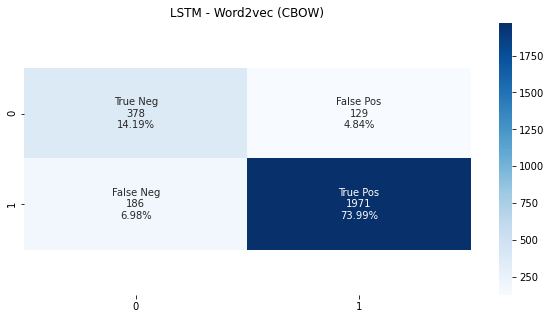


Accuracy:  0.8817567567567568


In [ ]:
evaluar_modelo(y_final_cbow, 'LSTM - Word2vec (CBOW)')

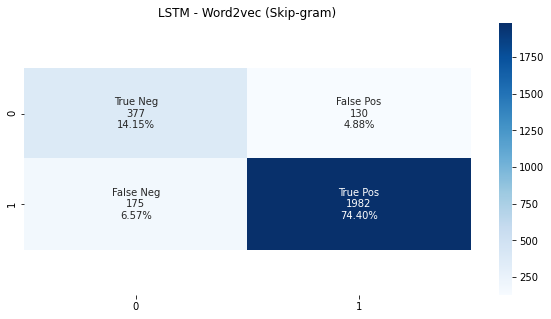


Accuracy:  0.8855105105105106


In [ ]:
evaluar_modelo(y_final_skip, 'LSTM - Word2vec (Skip-gram)')

## Recall:

In [ ]:
from sklearn.metrics import recall_score
recall_score(y_test, y_final_cbow, average='macro')

0.8296656269802734

In [ ]:
recall_score(y_test, y_final_skip, average='macro')

0.8312292714239864

## ROC Curve:

In [ ]:
redes_bert_fpr = pd.read_csv('redes_bert_fpr.csv', sep=',',header=None)
redes_bert_tpr = pd.read_csv('redes_bert_tpr.csv', sep=',',header=None)
bert_auc = pd.read_csv('bert_auc.csv', sep=',',header=None)

redes_bert_fpr = redes_bert_fpr.values
redes_bert_tpr = redes_bert_tpr.values

bert_auc = bert_auc.values[0][0]

In [ ]:
_, prob_lstm =clasificar(LSTM_UnaCapas_CBOW)
_, prob_gru_cbow = clasificar(GRU_DosCapas_CBOW)
_, prob_gru_skip = clasificar(GRU_UnaCapas_SKIP)
_, prob_bilstm = clasificar(BiLSTM_DosCapas_CBOW)

In [ ]:
# y_pred
from sklearn.metrics import roc_curve, roc_auc_score
r_probs = [0 for _ in range(len(y_test))]
redes_lstm = prob_lstm
redes_gru_cbow = prob_gru_cbow
redes_gru_skip = prob_gru_skip
redes_bilstm = prob_bilstm
#redes_probs = redes_probs#[:, 1]

r_auc = roc_auc_score(y_test, r_probs)
lstm_auc = roc_auc_score(y_test, redes_lstm)
gru_cbow_auc = roc_auc_score(y_test, redes_gru_cbow)
gru_skip_auc = roc_auc_score(y_test, redes_gru_skip)
bilstm_auc = roc_auc_score(y_test, redes_bilstm)


print('Predicción aleatoria: AUROC = %.3f' % (r_auc))
print('Modelo Red Neuronal LSTM Word2vec CBOW: AUROC = %.3f' % (lstm_auc))
print('Modelo Red Neuronal GRU Word2vec CBOW: AUROC = %.3f' % (gru_cbow_auc))
print('Modelo Red Neuronal GRU Word2vec SKIP: AUROC = %.3f' % (gru_skip_auc))
print('Modelo Red Neuronal BiLSTM Word2vec CBOW: AUROC = %.3f' % (bilstm_auc))
print('Modelo Red Neuronal BERT: AUROC = %.3f' % (bert_auc))

Predicción aleatoria: AUROC = 0.500
Modelo Red Neuronal LSTM Word2vec CBOW: AUROC = 0.982
Modelo Red Neuronal GRU Word2vec CBOW: AUROC = 0.979
Modelo Red Neuronal GRU Word2vec SKIP: AUROC = 0.980
Modelo Red Neuronal BiLSTM Word2vec CBOW: AUROC = 0.981
Modelo Red Neuronal BERT: AUROC = 0.995


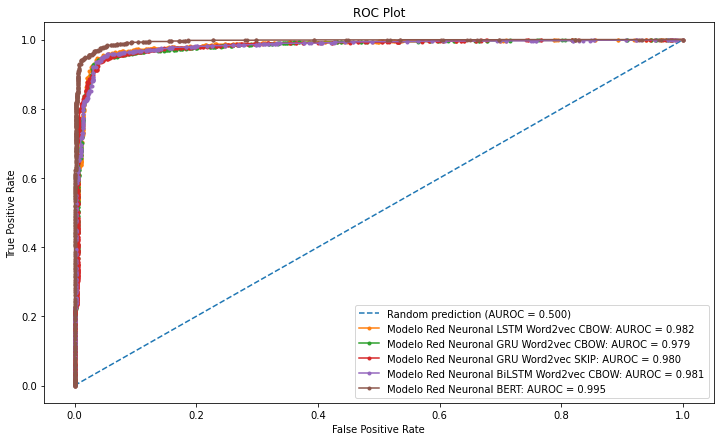

In [ ]:
r_fpr, r_tpr, _ = roc_curve(y_test, r_probs)
redes_lstm_fpr, redes_lstm_tpr, _ = roc_curve(y_test, redes_lstm)
redes_gru_cbow_fpr, redes_gru_cbow_tpr, _ = roc_curve(y_test, redes_gru_cbow)
redes_gru_skip_fpr, redes_gru_skip_tpr, _ = roc_curve(y_test, redes_gru_skip)
redes_bilstm_fpr, redes_bilstm_tpr, _ = roc_curve(y_test, redes_bilstm)
#redes_bert_fpr, redes_bert_tpr, _ = roc_curve(y_test, redes_BERT)

plt.figure(figsize=(12,7))
plt.plot(r_fpr, r_tpr, linestyle='--', label='Random prediction (AUROC = %0.3f)' % r_auc)
plt.plot(redes_lstm_fpr, redes_lstm_tpr, marker='.', label='Modelo Red Neuronal LSTM Word2vec CBOW: AUROC = %.3f' % lstm_auc)
plt.plot(redes_gru_cbow_fpr, redes_gru_cbow_tpr, marker='.', label='Modelo Red Neuronal GRU Word2vec CBOW: AUROC = %.3f' % gru_cbow_auc)
plt.plot(redes_gru_skip_fpr, redes_gru_skip_tpr, marker='.', label='Modelo Red Neuronal GRU Word2vec SKIP: AUROC = %.3f' % gru_skip_auc)
plt.plot(redes_bilstm_fpr, redes_bilstm_tpr, marker='.', label='Modelo Red Neuronal BiLSTM Word2vec CBOW: AUROC = %.3f' % bilstm_auc)
plt.plot(redes_bert_fpr, redes_bert_tpr, marker='.', label='Modelo Red Neuronal BERT: AUROC = %.3f' % bert_auc)
plt.title('ROC Plot')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()